# Analysis of the time to cessation of the stream wetting front in flume numerical experiments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from matplotlib.ticker import FormatStrFormatter
import os
import pickle
%matplotlib inline

Specify the experiment parameters to assist loading results and then load results

In [2]:
def load_obj(filename):
    if filename.endswith('.pkl'):
        with open(filename, 'rb') as f:
            print "Loading: ", filename
            p = pickle.load(f)
            return p
        # End with
    else:
        raise TypeError('File type not recognised as "pkl": {}'.format(filename))
    # End if                
    
theoretical_experiments = {'multi_uniform_var':True,
                           'multi_heterogeneous_k':True,
                           'multi_bed_elevation':True,
                           'multi_heterogeneous_mannings_n':False, # Not easily implemented yet due to HGS limitations
                           'multi_slope':True}

master_analysis = {key:{} for key in theoretical_experiments if theoretical_experiments[key]}                           
                           
samples = 30
flows = np.linspace(0, 3E-4, 31)
period_between_flow_changes = 2500.0
locs = np.arange(2500.0, 2500.0 * 31, 2500.0)

def mpd_to_mps(val):
    'Convert m/d to m/s'
    return val / 86400.            

uni_vars = {            
    # Soil properties (k~3.03E-4 m/s)
    'k': np.linspace(mpd_to_mps(1.), mpd_to_mps(50.), samples),  
    'porosity': np.linspace(0.2, 0.5, samples),
    'vg_alpha': np.linspace(0.8, 14.5, samples),
    'vg_beta': np.linspace(1.09, 2.68, samples),
    'vg_swr': np.linspace(0.045, 0.07, samples),
    # Bed properties
    'mannings_n': np.linspace(0.002, 0.2, samples),
    'slope': np.linspace(-0.001, -0.2, samples)    
    }
                            
hetero_vars = {'k': {'mu': 3.03E-4, 'sigmas': [1E-4, 1E-5, 1E-6]},
               'bed_elevation': {'mu': 0 , 'sigmas': [0.01, 0.001, 0.0001]},
               'mannings_n': {'mu': 0.024186654284876676, 'sigmas': [0.0001, 0.001, 0.01]}}

uni_vars_type = {
    # Soil properties
    'k': 'subsurface',  
    'porosity': 'subsurface',
    'vg_alpha': 'subsurface',
    'vg_beta': 'subsurface',
    'vg_swr': 'subsurface',
    # Bed properties
    'mannings_n': 'surface',
    'slope': 'surface'
    }

def load_csvs(targets):
    toe_locations = {}
    water_balances = {}
    for target in force_targets:
        suffix = target.split("_")[-1]
        toe_locations[target] = pd.read_csv("multi_slope/multi_slope_slope_{}_toe_locations.csv".format(suffix), index_col='Time')
        water_balances[target] = pd.read_csv("multi_slope/multi_slope_slope_{}_water_balances.csv".format(suffix), index_col='Time')
    return [toe_locations, water_balances, force_targets]

files = os.listdir('multi_slope')
files
force_targets = [f.split("_")[3] for f in files if 'toe_locations' in f] 

results={}
verbose = True
print('Analysing virtual experiments:')
for experiment in theoretical_experiments:
    if theoretical_experiments[experiment]:
        if verbose:
            print('    Analysing virtual experiment: {}'.format(experiment))
        if experiment == 'multi_uniform_var':
            for uni_var in uni_vars: 
                if uni_var != 'slope':
                    targets = []
                    if verbose:
                        print('      Analysing runs for variable: {}'.format(uni_var))
                    for val in uni_vars[uni_var]:
                        if verbose:
                            print('        Analysing run for variable val: {}'.format(val))
                        targets += ["{}_{}_{}".format(experiment, uni_var, val)]
                    # end for
                    results['{}_{}'.format(experiment, uni_var)] = load_obj('flow_v_toe_{}_{}.pkl'.format(experiment, uni_var))
                else:
                    targets = []
                    if verbose:
                        print('      Analysing runs for variable: {}'.format(uni_var))
                    for val in uni_vars[uni_var]:
                        if verbose:
                            print('        Analysing run for variable val: {}'.format(val))
                        targets += ["{}_{}_{}".format(experiment, uni_var, val)]
                    # end for
                    results['{}_{}'.format(experiment, uni_var)] = load_csvs(targets)
        
        elif experiment == 'multi_heterogeneous_k':
            for sigma in hetero_vars['k']['sigmas']:
                targets = []
                if verbose:
                    print('      Analysing sigma: {}'.format(sigma))
                for realisation in range(samples):
                    if verbose:
                        print('        Analysing realisation: {}'.format(realisation))
                    targets += ["{}_{}_{}".format(experiment, sigma, realisation)]
                results['{}_{}'.format(experiment, sigma)] = load_obj('flow_v_toe_{}_{}.pkl'.format(experiment, sigma))
        elif experiment == 'multi_heterogeneous_mannings_n':
            for sigma in hetero_vars['mannings_n']['sigmas']:
                for realisation in range(samples):
                    target = "{}_{}_{}".format(experiment, sigma, realisation)
        elif experiment == 'multi_bed_elevation':
            for sigma in hetero_vars['bed_elevation']['sigmas']:
                targets = []
                if verbose:
                    print('      Analysing sigma: {}'.format(sigma))
                for realisation in range(samples):
                    if verbose:
                        print('        Analysing realisation: {}'.format(realisation))
                    targets += ["{}_{}_{}".format(experiment, sigma, realisation)]
                results['{}_{}'.format(experiment, sigma)] = load_obj('flow_v_toe_{}_{}.pkl'.format(experiment, sigma))
        #elif experiment == 'multi_slope':
        #    for val in uni_vars['slope']:
        #        targets = []
        #        if verbose:
        #            print('      Analysing slope: {}'.format(val))
        #        targets += ["{}_{}_{}".format(experiment, 'slope', val)]
        #    results['{}_{}'.format(experiment, 'slope')] = load_obj('flow_v_toe_{}_{}.pkl'.format(experiment, 'slope'))
    else:
        print("NOT executing: {}".format(experiment))
    # end if    
    
inflow = pd.read_csv("./input_data/inflow.dat", skiprows=16, delim_whitespace=True, skipfooter=3, usecols=['time', 'value'])
inflow.index = inflow.time

flow_duration_per_flowrate = 2500.0

start_times = []
for row in inflow.iterrows():
    if row[0] == 0.0:
        continue
    start_times += [row[0]]

Analysing virtual experiments:
    Analysing virtual experiment: multi_slope
    Analysing virtual experiment: multi_bed_elevation
      Analysing sigma: 0.01
        Analysing realisation: 0
        Analysing realisation: 1
        Analysing realisation: 2
        Analysing realisation: 3
        Analysing realisation: 4
        Analysing realisation: 5
        Analysing realisation: 6
        Analysing realisation: 7
        Analysing realisation: 8
        Analysing realisation: 9
        Analysing realisation: 10
        Analysing realisation: 11
        Analysing realisation: 12
        Analysing realisation: 13
        Analysing realisation: 14
        Analysing realisation: 15
        Analysing realisation: 16
        Analysing realisation: 17
        Analysing realisation: 18
        Analysing realisation: 19
        Analysing realisation: 20
        Analysing realisation: 21
        Analysing realisation: 22
        Analysing realisation: 23
        Analysing realisation: 24
 

C:\progra~1\Anaconda2\lib\site-packages\ipykernel\__main__.py:135: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


In order to look at the time to cessation of the adancing stream front it is necessary to remove all periods where the stream wetting front was steady, i.e. to only include active change periods in the analysis

## Steps to identifying active change periods

1. Identify all flux change points
2. For each flux:
    - Look forward to the next change
    - Determine final toe location from previous flux
    - Move backwards in time to determine toe reversal location
    - Place marker at this point and remove all points forward to next flux change
    
    
Reasoning for the timing analysis:
The cumulative time it takes to reach steady state under different fluxes is valid if the time to complete vertical saturation is relatively negligible. In this model this is the case as it is a sand of 400 mm thickness. 

In [5]:
muvk_toe_loc = results['multi_uniform_var_k'][0]
inflows = results['multi_uniform_var_k'][1]['multi_uniform_var_k_0.0001093550447']['Fnodal_1'].unique()[1:]#.plot(y="Fnodal_1")
sorted_keys_list = ["multi_uniform_var_k_{}".format(x) for x in np.sort([float(x.split('_')[-1]) for x in muvk_toe_loc.keys()])]
K_uniform_vals = []
for ind, key in enumerate(sorted_keys_list):
    K_uniform_vals += ["{:4.3}".format(float(key.split('_')[-1])  * 86400.0)]

In [6]:
muvk_time_results = {}
for key in muvk_toe_loc.keys():
    print("Processing: {}".format(key))
    # First create a copy of the simulation time and toe location dataframe 
    toe_time = muvk_toe_loc[key].copy()

    for ind, time in enumerate(start_times[:-1]):
        next_time = start_times[ind + 1]
        # Define the final toe location at the end of inflow from time in start_times
        final_loc = toe_time.loc[start_times[ind + 1], 'toe_loc']
        toe_time_filter = toe_time[(toe_time.index >= time) & (toe_time.index <= next_time)].copy() #toe_time[toe_time.index >= time].copy()
        mask = toe_time_filter.values < final_loc
        for ind2, val in enumerate(mask):
            if ~val:
                first_false = ind2
                break
        mask[ind2] = True
        toe_time_filter = toe_time_filter[mask]
        toe_time_filter.index = toe_time_filter.index - toe_time_filter.index[0]
        toe_time_filter.loc[:, "flux_time"] = ind
        if ind == 0:
            transient_periods = toe_time_filter
        else:
            toe_time_filter.index = toe_time_filter.index + transient_periods.index[-1] + 1.0
            transient_periods = pd.concat([transient_periods, toe_time_filter])
    muvk_time_results[key] = transient_periods

Processing: multi_uniform_var_k_0.000344029374202
Processing: multi_uniform_var_k_0.0001093550447
Processing: multi_uniform_var_k_0.000559147509579
Processing: multi_uniform_var_k_8.97988505747e-05
Processing: multi_uniform_var_k_0.000500478927203
Processing: multi_uniform_var_k_0.000363585568327
Processing: multi_uniform_var_k_0.000422254150702
Processing: multi_uniform_var_k_1.15740740741e-05
Processing: multi_uniform_var_k_0.000304916985951
Processing: multi_uniform_var_k_0.000265804597701
Processing: multi_uniform_var_k_5.06864623244e-05
Processing: multi_uniform_var_k_0.000480922733078
Processing: multi_uniform_var_k_0.000207136015326
Processing: multi_uniform_var_k_7.02426564496e-05
Processing: multi_uniform_var_k_0.000187579821201
Processing: multi_uniform_var_k_0.000246248403576
Processing: multi_uniform_var_k_0.000402697956577
Processing: multi_uniform_var_k_0.000578703703704
Processing: multi_uniform_var_k_0.000128911238825
Processing: multi_uniform_var_k_0.000324473180077
Pr

In [7]:
time_to_ss = pd.DataFrame(index=inflows, columns=K_uniform_vals)
time_to_ss_from_increase = pd.DataFrame(index=inflows, columns=K_uniform_vals)
str_loc_at_ss = pd.DataFrame(index=inflows, columns=K_uniform_vals)
for key in muvk_toe_loc.keys():
    print("Processing: {}".format(key))
    # First create a copy of the simulation time and toe location dataframe 
    toe_time = muvk_toe_loc[key].copy()
    total_time = 0
    for ind, time in enumerate(start_times[:-1]):
        next_time = start_times[ind + 1]
        # Define the final toe location at the end of inflow from time in start_times
        final_loc = toe_time.loc[next_time, 'toe_loc']
        # Check if the end of the flume setup was reached and if so, set the time to steady-state (ss) as np.nan
        row = inflows[ind]
        col = "{:4.3}".format(float(key.split('_')[-1])  * 86400.0)
        if final_loc == 8.0:
            time_to_ss.loc[row, col] = -999.0 #np.nan
            print("    Reached end of flume")
            break 
        
        toe_time_filter = toe_time[(toe_time.index >= time) & (toe_time.index <= next_time)].copy()
        mask = toe_time_filter.values < final_loc
        # Check if the toe has reached a steady position by the time the inflow is increased and if not than set the
        # time to ss as np.nan
        if len(mask) == (sum(mask) + 1):
            time_to_ss.loc[row, col] = -9999.0 #np.nan
            print("    Steady-state not reached {} {}".format(len(mask), sum(mask) + 1))
            break 
            
        for ind2, val in enumerate(mask):
            if ~val:
                first_false = ind2
                break
        
        mask[ind2] = True
        toe_time_filter = toe_time_filter[mask]
        toe_time_filter.index = toe_time_filter.index - toe_time_filter.index[0]
        total_time += toe_time_filter.index[-1]
        time_to_ss_from_increase.loc[row, col] = toe_time_filter.index[-1]
        time_to_ss.loc[row, col] = total_time
        str_loc_at_ss.loc[row, col] = final_loc
        toe_time_filter.loc[:, "flux_time"] = ind

Processing: multi_uniform_var_k_0.000344029374202
Processing: multi_uniform_var_k_0.0001093550447
    Reached end of flume
Processing: multi_uniform_var_k_0.000559147509579
Processing: multi_uniform_var_k_8.97988505747e-05
    Reached end of flume
Processing: multi_uniform_var_k_0.000500478927203
Processing: multi_uniform_var_k_0.000363585568327
Processing: multi_uniform_var_k_0.000422254150702
Processing: multi_uniform_var_k_1.15740740741e-05
    Reached end of flume
Processing: multi_uniform_var_k_0.000304916985951
Processing: multi_uniform_var_k_0.000265804597701
    Reached end of flume
Processing: multi_uniform_var_k_5.06864623244e-05
    Reached end of flume
Processing: multi_uniform_var_k_0.000480922733078
Processing: multi_uniform_var_k_0.000207136015326
    Reached end of flume
Processing: multi_uniform_var_k_7.02426564496e-05
    Reached end of flume
Processing: multi_uniform_var_k_0.000187579821201
    Reached end of flume
Processing: multi_uniform_var_k_0.000246248403576
  

## Make the plots of time to cessation vs inflow

In [8]:
def plot_tts(time_to_ss, output_fname="Stream front advancement cessation lines.png", title=""):
    time_to_ss_tmp = time_to_ss.copy()
    time_to_ss_tmp[time_to_ss_tmp == -999.0] = np.nan
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    n = len(time_to_ss.columns) + 10
    cmap = plt.cm.get_cmap('viridis', n)
    for ind, col in enumerate(time_to_ss.columns):
        color = cmap((ind + 1)/float(n))
        time_to_ss_tmp.plot(y=col, linestyle='-', marker='o', markeredgecolor='none',
                            color=cmap((ind + 1)/float(n)), #marker='o', markeredgecolor='none' 
                ax=ax, label=col).legend(
            loc='center left', bbox_to_anchor=(1, 0.5), title=title, prop={'size':8})
    ax.set_ylabel("Stream front advancement cessation time [s]")
    ax.set_xlabel("Flume inflow rate [m$^3$s$^{-1}$]")
    plt.subplots_adjust(right=0.85)
    plt.savefig(output_fname, dpi=300)

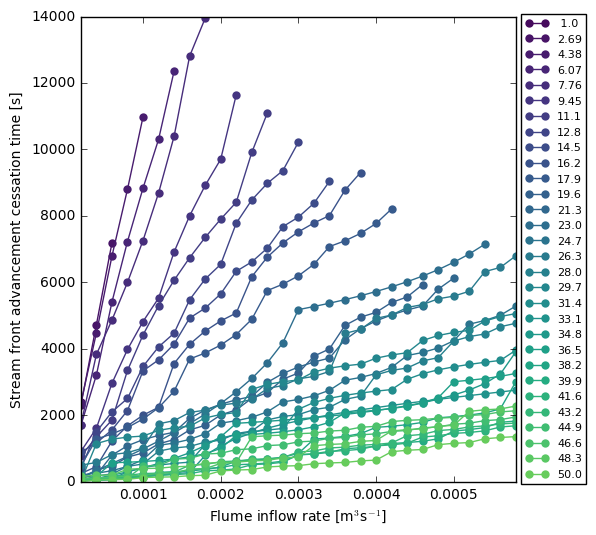

In [9]:
plot_tts(time_to_ss)

# Analyse heterogeneous K simulations

In [10]:
hetero_prefix = 'multi_heterogeneous_k_'
sigmas = ['0.0001', '1e-05', '1e-06']

In [11]:
hetero_k_time_results = {}
for sigma in sigmas:
    hetero_k_toe_loc = results['multi_heterogeneous_k_{}'.format(sigma)][0]
    inflows = results['multi_heterogeneous_k_{}'.format(sigma)][1]['multi_heterogeneous_k_{}_0'.format(sigma)]['Fnodal_1'].unique()[1:]#.plot(y="Fnodal_1")
    sorted_keys_list = results['multi_heterogeneous_k_{}'.format(sigma)][-1]
    for key in hetero_k_toe_loc.keys():
        print("Processing: {}".format(key))
        # First create a copy of the simulation time and toe location dataframe 
        toe_time = hetero_k_toe_loc[key].copy()

        for ind, time in enumerate(start_times[:-1]):
            next_time = start_times[ind + 1]
            # Define the final toe location at the end of inflow from time in start_times
            final_loc = toe_time.loc[start_times[ind + 1], 'toe_loc']
            toe_time_filter = toe_time[(toe_time.index >= time) & (toe_time.index <= next_time)].copy() #toe_time[toe_time.index >= time].copy()
            mask = toe_time_filter.values < final_loc
            for ind2, val in enumerate(mask):
                if ~val:
                    first_false = ind2
                    break
            mask[ind2] = True
            toe_time_filter = toe_time_filter[mask]
            toe_time_filter.index = toe_time_filter.index - toe_time_filter.index[0]
            toe_time_filter.loc[:, "flux_time"] = ind
            if ind == 0:
                transient_periods = toe_time_filter
            else:
                toe_time_filter.index = toe_time_filter.index + transient_periods.index[-1] + 1.0
                transient_periods = pd.concat([transient_periods, toe_time_filter])
        hetero_k_time_results[key] = transient_periods

Processing: multi_heterogeneous_k_0.0001_4
Processing: multi_heterogeneous_k_0.0001_5
Processing: multi_heterogeneous_k_0.0001_6
Processing: multi_heterogeneous_k_0.0001_7
Processing: multi_heterogeneous_k_0.0001_0
Processing: multi_heterogeneous_k_0.0001_1
Processing: multi_heterogeneous_k_0.0001_2
Processing: multi_heterogeneous_k_0.0001_3
Processing: multi_heterogeneous_k_0.0001_8
Processing: multi_heterogeneous_k_0.0001_9
Processing: multi_heterogeneous_k_0.0001_27
Processing: multi_heterogeneous_k_0.0001_26
Processing: multi_heterogeneous_k_0.0001_25
Processing: multi_heterogeneous_k_0.0001_24
Processing: multi_heterogeneous_k_0.0001_23
Processing: multi_heterogeneous_k_0.0001_22
Processing: multi_heterogeneous_k_0.0001_21
Processing: multi_heterogeneous_k_0.0001_20
Processing: multi_heterogeneous_k_0.0001_29
Processing: multi_heterogeneous_k_0.0001_28
Processing: multi_heterogeneous_k_0.0001_18
Processing: multi_heterogeneous_k_0.0001_19
Processing: multi_heterogeneous_k_0.0001_1

In [12]:
hk_samples = []
for sigma in sigmas:
    hk_samples += ["{}_{}".format(sigma, str(int(x))) for x in range(30)]

In [13]:
time_to_ss_hk = pd.DataFrame(index=inflows, columns=hk_samples)
time_to_ss_hk_from_increase = pd.DataFrame(index=inflows, columns=hk_samples)
str_loc_at_ss_hk = pd.DataFrame(index=inflows, columns=hk_samples)
for sigma in sigmas:
    hetero_k_toe_loc = results['multi_heterogeneous_k_{}'.format(sigma)][0]
    inflows = results['multi_heterogeneous_k_{}'.format(sigma)][1]['multi_heterogeneous_k_{}_0'.format(sigma)]['Fnodal_1'].unique()[1:]#.plot(y="Fnodal_1")
    sorted_keys_list = results['multi_heterogeneous_k_{}'.format(sigma)][-1]    
    for key in hetero_k_toe_loc.keys():
        print("Processing: {}".format(key))
        # First create a copy of the simulation time and toe location dataframe 
        toe_time = hetero_k_toe_loc[key].copy()
        total_time = 0
        for ind, time in enumerate(start_times[:-1]):
            next_time = start_times[ind + 1]
            # Define the final toe location at the end of inflow from time in start_times
            final_loc = toe_time.loc[next_time, 'toe_loc']
            # Check if the end of the flume setup was reached and if so, set the time to steady-state (ss) as np.nan
            row = inflows[ind]
            col = "{}_{}".format(sigma, int(key.split('_')[-1]))
            if final_loc == 8.0:
                time_to_ss.loc[row, col] = -999.0 #np.nan
                print("    Reached end of flume")
                break 

            toe_time_filter = toe_time[(toe_time.index >= time) & (toe_time.index <= next_time)].copy()
            mask = toe_time_filter.values < final_loc
            # Check if the toe has reached a steady position by the time the inflow is increased and if not than set the
            # time to ss as np.nan
            if len(mask) == (sum(mask) + 1):
                time_to_ss_hk.loc[row, col] = -9999.0 #np.nan
                print("    Steady-state not reached {} {}".format(len(mask), sum(mask) + 1))
                break 

            for ind2, val in enumerate(mask):
                if ~val:
                    first_false = ind2
                    break

            mask[ind2] = True
            toe_time_filter = toe_time_filter[mask]
            toe_time_filter.index = toe_time_filter.index - toe_time_filter.index[0]
            total_time += toe_time_filter.index[-1]
            time_to_ss_hk_from_increase.loc[row, col] = toe_time_filter.index[-1]
            time_to_ss_hk.loc[row, col] = total_time
            str_loc_at_ss_hk.loc[row, col] = final_loc
            toe_time_filter.loc[:, "flux_time"] = ind

Processing: multi_heterogeneous_k_0.0001_4
Processing: multi_heterogeneous_k_0.0001_5
Processing: multi_heterogeneous_k_0.0001_6
Processing: multi_heterogeneous_k_0.0001_7
Processing: multi_heterogeneous_k_0.0001_0
Processing: multi_heterogeneous_k_0.0001_1
Processing: multi_heterogeneous_k_0.0001_2
Processing: multi_heterogeneous_k_0.0001_3
Processing: multi_heterogeneous_k_0.0001_8
Processing: multi_heterogeneous_k_0.0001_9
Processing: multi_heterogeneous_k_0.0001_27
Processing: multi_heterogeneous_k_0.0001_26
Processing: multi_heterogeneous_k_0.0001_25
Processing: multi_heterogeneous_k_0.0001_24
Processing: multi_heterogeneous_k_0.0001_23
Processing: multi_heterogeneous_k_0.0001_22
Processing: multi_heterogeneous_k_0.0001_21
Processing: multi_heterogeneous_k_0.0001_20
Processing: multi_heterogeneous_k_0.0001_29
Processing: multi_heterogeneous_k_0.0001_28
Processing: multi_heterogeneous_k_0.0001_18
Processing: multi_heterogeneous_k_0.0001_19
Processing: multi_heterogeneous_k_0.0001_1

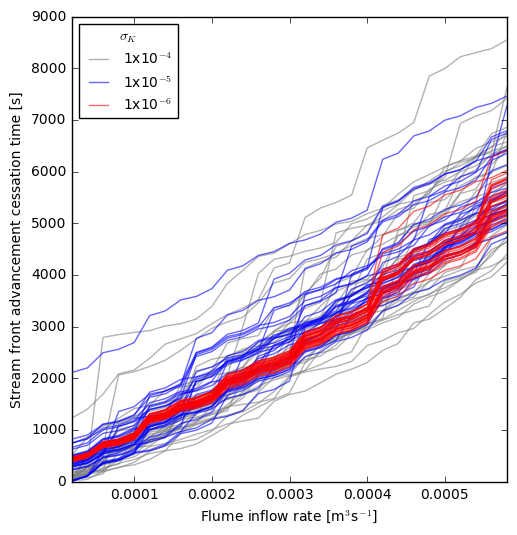

In [14]:
def plot_tts_mono(ax, time_to_ss_tmp, color='gray'):
    for ind, col in enumerate(time_to_ss_tmp.columns):
        time_to_ss_tmp.plot(y=col, linestyle='-', #marker='o', markeredgecolor='none',
                            color=color, ax=ax, label=col, legend=False, alpha=0.6)

time_to_ss_tmp = time_to_ss_hk.copy()
time_to_ss_tmp[time_to_ss_tmp == -999.0] = np.nan
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
for sigma, color in zip(sigmas, ['gray', 'blue', 'red']):
    plot_tts_mono(ax, time_to_ss_hk[[x for x in time_to_ss_hk.columns if sigma in x]], color=color)
ax.set_ylabel("Stream front advancement cessation time [s]")
ax.set_xlabel("Flume inflow rate [m$^3$s$^{-1}$]")
output_fname="Stream_front_advancement_cessation_lines_hetero_K.png"

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray', lw=1, alpha=0.6),
                Line2D([0], [0], color='blue', lw=1, alpha=0.6),
                Line2D([0], [0], color='red', lw=1, alpha=0.6)]

ax.legend(custom_lines, ['1x10$^{-4}$', '1x10$^{-5}$', '1x10$^{-6}$'], title='$\sigma _{K}$', loc='upper left',
         prop={'size': 10})

plt.subplots_adjust(right=0.85)
plt.savefig(output_fname, dpi=300)

# Analyse heterogeneous bed elevation sims

In [15]:
results.keys()

['multi_uniform_var_vg_swr',
 'multi_uniform_var_slope',
 'multi_uniform_var_mannings_n',
 'multi_bed_elevation_0.0001',
 'multi_bed_elevation_0.001',
 'multi_uniform_var_porosity',
 'multi_uniform_var_vg_beta',
 'multi_bed_elevation_0.01',
 'multi_heterogeneous_k_0.0001',
 'multi_uniform_var_k',
 'multi_heterogeneous_k_1e-05',
 'multi_heterogeneous_k_1e-06',
 'multi_uniform_var_vg_alpha']

In [16]:
mb_prefix = 'multi_bed_elevation_'
mb_sigmas = ['0.01', '0.001', '0.0001']

In [17]:
multi_bed_time_results = {}
for sigma in mb_sigmas:
    multi_bed_toe_loc = results['multi_bed_elevation_{}'.format(sigma)][0]
    inflows = results['multi_bed_elevation_{}'.format(sigma)][1]['multi_bed_elevation_{}_0'.format(sigma)]['Fnodal_1'].unique()[1:]#.plot(y="Fnodal_1")
    sorted_keys_list = results['multi_bed_elevation_{}'.format(sigma)][-1]
    for key in multi_bed_toe_loc.keys():
        print("Processing: {}".format(key))
        # First create a copy of the simulation time and toe location dataframe 
        toe_time = multi_bed_toe_loc[key].copy()

        for ind, time in enumerate(start_times[:-1]):
            next_time = start_times[ind + 1]
            # Define the final toe location at the end of inflow from time in start_times
            final_loc = toe_time.loc[start_times[ind + 1], 'toe_loc']
            toe_time_filter = toe_time[(toe_time.index >= time) & (toe_time.index <= next_time)].copy() #toe_time[toe_time.index >= time].copy()
            mask = toe_time_filter.values < final_loc
            for ind2, val in enumerate(mask):
                if ~val:
                    first_false = ind2
                    break
            mask[ind2] = True
            toe_time_filter = toe_time_filter[mask]
            toe_time_filter.index = toe_time_filter.index - toe_time_filter.index[0]
            toe_time_filter.loc[:, "flux_time"] = ind
            if ind == 0:
                transient_periods = toe_time_filter
            else:
                toe_time_filter.index = toe_time_filter.index + transient_periods.index[-1] + 1.0
                transient_periods = pd.concat([transient_periods, toe_time_filter])
        multi_bed_time_results[key] = transient_periods

Processing: multi_bed_elevation_0.01_25
Processing: multi_bed_elevation_0.01_24
Processing: multi_bed_elevation_0.01_27
Processing: multi_bed_elevation_0.01_26
Processing: multi_bed_elevation_0.01_21
Processing: multi_bed_elevation_0.01_20
Processing: multi_bed_elevation_0.01_23
Processing: multi_bed_elevation_0.01_22
Processing: multi_bed_elevation_0.01_29
Processing: multi_bed_elevation_0.01_28
Processing: multi_bed_elevation_0.01_2
Processing: multi_bed_elevation_0.01_3
Processing: multi_bed_elevation_0.01_0
Processing: multi_bed_elevation_0.01_1
Processing: multi_bed_elevation_0.01_6
Processing: multi_bed_elevation_0.01_7
Processing: multi_bed_elevation_0.01_4
Processing: multi_bed_elevation_0.01_5
Processing: multi_bed_elevation_0.01_8
Processing: multi_bed_elevation_0.01_9
Processing: multi_bed_elevation_0.01_10
Processing: multi_bed_elevation_0.01_11
Processing: multi_bed_elevation_0.01_12
Processing: multi_bed_elevation_0.01_13
Processing: multi_bed_elevation_0.01_14
Processing

In [18]:
mb_samples = []
for sigma in mb_sigmas:
    mb_samples += ["{}_{}".format(sigma, str(int(x))) for x in range(30)]

In [19]:
time_to_ss_mb = pd.DataFrame(index=inflows, columns=mb_samples)
time_to_ss_mb_from_increase = pd.DataFrame(index=inflows, columns=mb_samples)
str_loc_at_ss_mb = pd.DataFrame(index=inflows, columns=mb_samples)
for sigma in mb_sigmas:
    multi_bed_toe_loc = results['multi_bed_elevation_{}'.format(sigma)][0]
    inflows = results['multi_bed_elevation_{}'.format(sigma)][1]['multi_bed_elevation_{}_0'.format(sigma)]['Fnodal_1'].unique()[1:]#.plot(y="Fnodal_1")
    sorted_keys_list = results['multi_bed_elevation_{}'.format(sigma)][-1]
    for key in multi_bed_toe_loc.keys():
        print("Processing: {}".format(key))
        # First create a copy of the simulation time and toe location dataframe 
        toe_time = multi_bed_toe_loc[key].copy()
        total_time = 0
        for ind, time in enumerate(start_times[:-1]):
            next_time = start_times[ind + 1]
            # Define the final toe location at the end of inflow from time in start_times
            final_loc = toe_time.loc[next_time, 'toe_loc']
            # Check if the end of the flume setup was reached and if so, set the time to steady-state (ss) as np.nan
            row = inflows[ind]
            col = "{}_{}".format(sigma, int(key.split('_')[-1]))
            if final_loc == 8.0:
                time_to_ss.loc[row, col] = -999.0 #np.nan
                print("    Reached end of flume")
                break 

            toe_time_filter = toe_time[(toe_time.index >= time) & (toe_time.index <= next_time)].copy()
            mask = toe_time_filter.values < final_loc
            # Check if the toe has reached a steady position by the time the inflow is increased and if not than set the
            # time to ss as np.nan
            if len(mask) == (sum(mask) + 1):
                time_to_ss_mb.loc[row, col] = -9999.0 #np.nan
                print("    Steady-state not reached {} {}".format(len(mask), sum(mask) + 1))
                break 

            for ind2, val in enumerate(mask):
                if ~val:
                    first_false = ind2
                    break

            mask[ind2] = True
            toe_time_filter = toe_time_filter[mask]
            toe_time_filter.index = toe_time_filter.index - toe_time_filter.index[0]
            total_time += toe_time_filter.index[-1]
            time_to_ss_mb_from_increase.loc[row, col] = toe_time_filter.index[-1]
            time_to_ss_mb.loc[row, col] = total_time
            str_loc_at_ss_mb.loc[row, col] = final_loc
            toe_time_filter.loc[:, "flux_time"] = ind

Processing: multi_bed_elevation_0.01_25
Processing: multi_bed_elevation_0.01_24
Processing: multi_bed_elevation_0.01_27
Processing: multi_bed_elevation_0.01_26
Processing: multi_bed_elevation_0.01_21
Processing: multi_bed_elevation_0.01_20
Processing: multi_bed_elevation_0.01_23
Processing: multi_bed_elevation_0.01_22
Processing: multi_bed_elevation_0.01_29
Processing: multi_bed_elevation_0.01_28
Processing: multi_bed_elevation_0.01_2
Processing: multi_bed_elevation_0.01_3
Processing: multi_bed_elevation_0.01_0
Processing: multi_bed_elevation_0.01_1
Processing: multi_bed_elevation_0.01_6
Processing: multi_bed_elevation_0.01_7
Processing: multi_bed_elevation_0.01_4
Processing: multi_bed_elevation_0.01_5
Processing: multi_bed_elevation_0.01_8
Processing: multi_bed_elevation_0.01_9
Processing: multi_bed_elevation_0.01_10
Processing: multi_bed_elevation_0.01_11
Processing: multi_bed_elevation_0.01_12
Processing: multi_bed_elevation_0.01_13
Processing: multi_bed_elevation_0.01_14
Processing

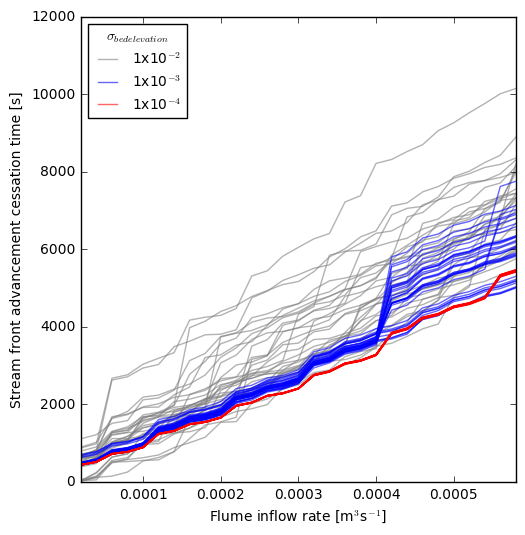

In [22]:
def plot_tts_mono(ax, time_to_ss_tmp, color='gray'):
    for ind, col in enumerate(time_to_ss_tmp.columns):
        time_to_ss_tmp.plot(y=col, linestyle='-', #marker='o', markeredgecolor='none',
                            color=color, ax=ax, label=col, legend=False, alpha=0.6)

time_to_ss_tmp = time_to_ss_mb.copy()
time_to_ss_tmp[time_to_ss_tmp == -999.0] = np.nan
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
for sigma, color in zip(mb_sigmas, ['gray', 'blue', 'red']):
    plot_tts_mono(ax, time_to_ss_mb[[x for x in time_to_ss_mb.columns if sigma in x]], color=color)
ax.set_ylabel("Stream front advancement cessation time [s]")
ax.set_xlabel("Flume inflow rate [m$^3$s$^{-1}$]")
output_fname="Stream_front_advancement_cessation_lines_bed_elevation.png"

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray', lw=1, alpha=0.6),
                Line2D([0], [0], color='blue', lw=1, alpha=0.6),
                Line2D([0], [0], color='red', lw=1, alpha=0.6)]

ax.legend(custom_lines, ['1x10$^{-2}$', '1x10$^{-3}$', '1x10$^{-4}$'], title='$\sigma _{bed elevation}$', loc='upper left',
         prop={'size': 10})

plt.subplots_adjust(right=0.85)
plt.savefig(output_fname, dpi=300)

## Combining plots of hetero K and bed elevation

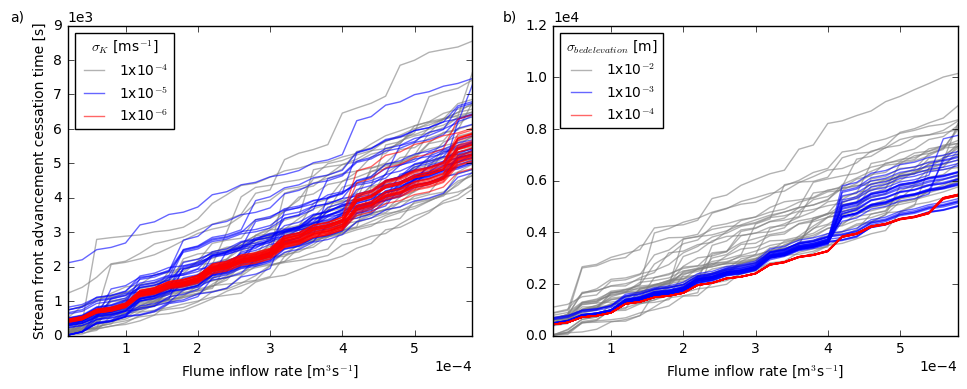

In [21]:
def plot_tts_mono(ax, time_to_ss_tmp, color='gray'):
    for ind, col in enumerate(time_to_ss_tmp.columns):
        time_to_ss_tmp.plot(y=col, linestyle='-', #marker='o', markeredgecolor='none',
                            color=color, ax=ax, label=col, legend=False, alpha=0.6)


#time_to_ss_tmp = time_to_ss_hk.copy()
#time_to_ss_tmp[time_to_ss_tmp == -999.0] = np.nan
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
for sigma, color in zip(sigmas, ['gray', 'blue', 'red']):
    plot_tts_mono(ax, time_to_ss_hk[[x for x in time_to_ss_hk.columns if sigma in x]], color=color)
ax.set_ylabel("Stream front advancement cessation time [s]")
ax.set_xlabel("Flume inflow rate [m$^3$s$^{-1}$]")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray', lw=1, alpha=0.6),
                Line2D([0], [0], color='blue', lw=1, alpha=0.6),
                Line2D([0], [0], color='red', lw=1, alpha=0.6)]

ax.legend(custom_lines, ['1x10$^{-4}$', '1x10$^{-5}$', '1x10$^{-6}$'], title='$\sigma _{K}$ [ms$^{-1}$]', loc='upper left',
         prop={'size': 10})
plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
#time_to_ss_tmp = time_to_ss_mb.copy()
#time_to_ss_tmp[time_to_ss_tmp == -999.0] = np.nan
ax2 = fig.add_subplot(122)
for sigma, color in zip(mb_sigmas, ['gray', 'blue', 'red']):
    plot_tts_mono(ax2, time_to_ss_mb[[x for x in time_to_ss_mb.columns if sigma in x]], color=color)
#ax2.set_ylabel("Stream front advancement cessation time [s]")
ax2.set_xlabel("Flume inflow rate [m$^3$s$^{-1}$]")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray', lw=1, alpha=0.6),
                Line2D([0], [0], color='blue', lw=1, alpha=0.6),
                Line2D([0], [0], color='red', lw=1, alpha=0.6)]

ax2.legend(custom_lines, ['1x10$^{-2}$', '1x10$^{-3}$', '1x10$^{-4}$'], title='$\sigma _{bed elevation}$ [m]', loc='upper left',
         prop={'size': 10})
plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))

ax.text(-0.00006, 9150, 'a)')
ax2.text(-0.00005, 12200, 'b)')

output_fname="Stream_front_advancement_cessation_lines_bedel_and_K.png"
plt.subplots_adjust(top=0.9, right=0.97, left=0.08)
plt.savefig(output_fname, dpi=300)